In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import ast
import os

import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from sklearn.dummy import DummyRegressor
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from scipy.stats import gaussian_kde

from shared_astro_utils import matching_utils

from zoobot.active_learning import metrics as zoobot_metrics
from zoobot.active_learning import simulated_metrics

In [3]:
save_dir = '../analysis/ds_nair'
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

### Load Catalogs

In [4]:
!pwd

/data/repos/zoobot/notebooks


In [5]:
mhc_loc = '../data/mhc/ZOO_model_full_catalogue.fit'
if not os.path.isfile(mhc_loc):
    !dvc pull -r s3 {mhc_loc}.dvc

In [6]:
mhc_catalog = Table.read(mhc_loc)

In [7]:
mhc_catalog['dr7objid'] = [str(x) for x in mhc_catalog['dr7objid']]

In [8]:
mhc_catalog = mhc_catalog.to_pandas()

In [9]:
gz_catalog_loc = '../data/gz2/gz2_classifications_and_subjects.csv'
if not os.path.isfile(gz_catalog_loc):
    !dvc pull -r s3 {gz_catalog_loc}.dvc

In [10]:
gz_catalog = pd.read_csv(gz_catalog_loc, dtype={'dr7objid': str})

### Check Data

In [11]:
mhc_catalog.iloc[0]

dr7objid        587722952230174996
galcount                         1
P_disk                 3.54431e-05
P_edge_on                 0.646749
P_bar_GZ2               0.00570267
P_bulge                 0.00223408
P_cigar                   0.992602
P_merg                   0.0210895
P_bar_Nair10              0.384967
TT_pred                    3.40424
P_S0                      0.970816
Name: 0, dtype: object

In [12]:
gz_catalog.iloc[0]

dr7objid                                                                                        587732591714893851
ra_subject                                                                                                 179.043
dec_subject                                                                                                60.5225
rastring                                                                                               11:56:10.32
decstring                                                                                              +60:31:21.1
sample                                                                                                    original
gz2_class                                                                                                     Sc+t
total_classifications                                                                                           45
total_votes                                                                     

### Merge

In [13]:
assert type(gz_catalog.iloc[0]['dr7objid']) == type(mhc_catalog.iloc[0]['dr7objid']) == str

In [14]:
df = pd.merge(gz_catalog, mhc_catalog, on='dr7objid', how='inner')

In [15]:
len(gz_catalog), len(mhc_catalog), len(df)

(239695, 670722, 234795)

### Filter to current shard galaxies

In [16]:
df['bar_total-votes'] = df['t03_bar_a06_bar_count'] + df['t03_bar_a07_no_bar_count']
df['bar_fraction'] = df['t03_bar_a06_bar_count'] / df['bar_total-votes']
df = df[df['bar_total-votes'] > 10]
len(df)

73354

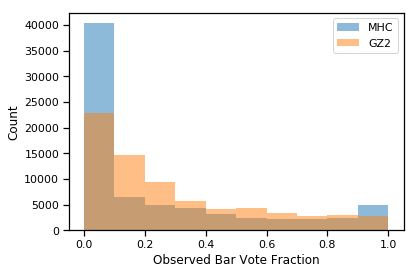

In [17]:
fig, ax = plt.subplots()
alpha = 0.5
ax.hist(df['P_bar_GZ2'], alpha=alpha)
ax.hist(df['bar_fraction'], alpha=alpha)
ax.set_xlabel('Observed Bar Vote Fraction')
ax.set_ylabel('Count')
ax.legend(['MHC', 'GZ2'])

### Baseline

rmse is not really the right thing to measure, but it'll do

In [18]:
clf = DummyRegressor()
train_df, test_df = df[:50000], df[50000:]
X_train = np.random.rand(len(train_df), 1)
X_test = np.random.rand(len(test_df), 1)
Y_train = train_df['bar_fraction']
Y_test = test_df['bar_fraction']

clf.fit(X_train, Y_train)
predictions = clf.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(Y_test, predictions))
rmse  

0.2607518098536792

### Compare Against Nair (appeal to expert)

DS trained on GZ2 with 0.2 or 0.8 prob, and n total votes > 5 ('high confidence sample')

DS trained on Nair with all bars, initializing from trained GZ model.

Should be able to do something like: 

Regress GZ2 to Nair to predict strong bars
Ask model to predict strong bars
Compare to DS predictions of strong bars

Should first check how many strong bars - only 24??

In [19]:
nair_loc = '../data/nair_sdss_catalog_interpreted.csv'
if not os.path.isfile(nair_loc):
    !dvc pull -r s3 {nair_loc}.dvc
nair_df = pd.read_csv(nair_loc)

In [20]:
nair_df.iloc[0]

iauname        J155341.74-003422.84
zs                            0.078
q_zs                              1
g_mag                         15.82
r_mag                        15.058
log_m_                       11.083
age                           4.459
b_a                           0.794
sigma                        143.68
tt                                3
bar                               0
ring                             36
f_ring                            0
lens                              0
ttq                               0
pair                              0
f_pair                            0
int                               0
nt                                0
rc3                                
ra                          238.424
dec                       -0.573011
has_bar                       False
has_ring                       True
bar_types                        []
ring_types    ['inner', 'min_four']
Name: 0, dtype: object

In [21]:
nair_df['bar_types'] = nair_df['bar_types'].apply(ast.literal_eval)

In [22]:
nair_df['has_strong_bar'] = ['strong' in bars for bars in nair_df['bar_types']]

In [23]:
nair_df['has_strong_bar'].sum(), nair_df['has_bar'].sum()

(210, 2612)

In [24]:
matched, unmatched = matching_utils.match_galaxies_to_catalog_pandas(
    galaxies=nair_df,
    catalog=df,
    galaxy_suffix='_nair'
)

In [25]:
len(matched), len(unmatched)  # seems a bit low, no?

(6051, 7983)

In [26]:
sum(['strong' in bars for bars in matched['bar_types']])

142

#### Typical GZ2 Bar Fractions (for interest only)

In [27]:
# fig, ax = plt.subplots()
# has_strong_bar = matched[matched['has_strong_bar']]['bar_fraction']
# no_strong_bar = matched[~matched['has_strong_bar']]['bar_fraction']
# strong_kde = gaussian_kde(has_strong_bar)
# no_strong_kde = gaussian_kde(no_strong_bar)
# x = np.linspace(0., 1., 300)
# plt.plot(x, strong_kde(x), label='nair: strong bar')
# plt.plot(x, no_strong_kde(x), label='nair: not strong bar')
# ax.set_xlabel('GZ2 Bar Fraction')
# ax.set_ylabel('Prob. Dens. of Having Bar Fraction')

Text(0,0.5,'Prob. Dens. of Having Bar Fraction')

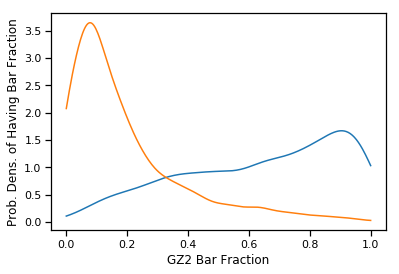

In [28]:
fig, ax = plt.subplots()
has_bar = matched[matched['has_bar']]['bar_fraction']
no_bar = matched[~matched['has_bar']]['bar_fraction']
bar_kde = gaussian_kde(has_bar)
no_bar_kde = gaussian_kde(no_bar)
x = np.linspace(0., 1., 300)
plt.plot(x, bar_kde(x), label='nair: strong bar')
plt.plot(x, no_bar_kde(x), label='nair: not strong bar')
ax.set_xlabel('GZ2 Bar Fraction')
ax.set_ylabel('Prob. Dens. of Having Bar Fraction')

### Predict Nair from GZ2 Votes (WWND) with Logistic Regression

In [29]:
train_df, test_df = train_test_split(matched, test_size=0.2, stratify=matched['has_bar'])

In [30]:
# strong_clf = LogisticRegression()
# strong_clf.fit(matched['bar_fraction'].values.reshape(-1, 1), matched['has_strong_bar'])
# strong_predictions = strong_clf.predict_proba(matched['bar_fraction'].values.reshape(-1, 1))[:, 1]
# sns.scatterplot(matched['bar_fraction'].values, predictions)
# gz2_expected_strong_bars = sum(strong_predictions)
# print(gz2_expected_strong_bars)

In [31]:
sns.set_style('white')

Expected bars: 396.1 Actual bars: 379


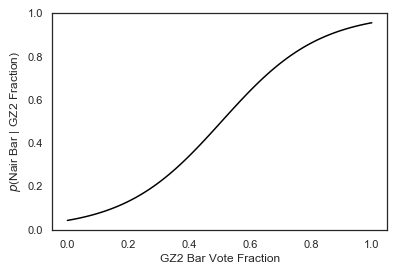

In [32]:
bar_clf = LogisticRegression()
bar_clf.fit(train_df['bar_fraction'].values.reshape(-1, 1), train_df['has_bar'])

def p_bar_given_gz(bar_fractions): return bar_clf.predict_proba(bar_fractions.values.reshape(-1, 1))[:, 1]

# sns.scatterplot(train_df['bar_fraction'].values, p_bar_given_gz(train_df['bar_fraction']))
fig, ax = plt.subplots()
x = pd.Series(np.linspace(0., 1., 100))
ax.plot(x, p_bar_given_gz(x), 'k')
ax.set_xlabel('GZ2 Bar Vote Fraction')
ax.set_ylabel(r'$p$(Nair Bar | GZ2 Fraction)')
plt.savefig(os.path.join(save_dir, 'gz2_fraction_to_nair_latest.png'))

gz2_predictions = p_bar_given_gz(test_df['bar_fraction'])

# should be similar total num. of expected/observed bars if predict_proba is well-calibrated
gz2_expected_bars = np.sum(gz2_predictions)
print('Expected bars: {:.1f} Actual bars: {:.0f}'.format(gz2_expected_bars, test_df['has_bar'].sum()))

In [33]:
sum(test_df['P_bar_Nair10']), sum(test_df['P_bar_GZ2'])

(559.0407092603091, 356.20986756243656)

Next question: how can you do using the probabilistic model predictions? Hopefully, about as well as with GZ2 predictions but including a window of uncertainty.

In [34]:
state_dir = '../analysis/uncertainty/al-binomial/bars-full-nair'
model_name = 'bars-full-nair'
state = zoobot_metrics.load_iteration_state(state_dir)
model = zoobot_metrics.Model(state, name=model_name)
df['subject_id'] = df['id'].astype(str)
df['total_votes']  = df['bar_total-votes']
df['label']  = df['t03_bar_a06_bar_count']

gz_catalog['bar_total-votes'] = gz_catalog['t03_bar_a06_bar_count'] + gz_catalog['t03_bar_a07_no_bar_count']
gz_catalog['subject_id'] = gz_catalog['id'].astype(str)
gz_catalog['total_votes']  = gz_catalog['bar_total-votes']
gz_catalog['label']  = gz_catalog['t03_bar_a06_bar_count']

In [35]:
assert set(model.id_strs) - set(gz_catalog['subject_id'].values) == set()

In [36]:
sim_model = simulated_metrics.SimulatedModel(model, gz_catalog)

/Data/repos/zoobot/zoobot/active_learning/simulated_metrics.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  filtered_catalog['subject_id'] = filtered_catalog['subject_id'].astype(str)


In [37]:
 # samples from model for gz2 mean bar votes

gz2_dl_df = pd.DataFrame({'rho': sim_model.mean_rho_prediction, 'id_str': sim_model.model.id_strs})
# # gz2_dl_probs = bin_probs_of_samples(gz2_dl_predictions, n_votes=n_votes).mean(axis=1)  # reduce over forward passes
# gz2_dl_probs = np.ones((len(test_df), n_votes)) / n_votes

In [38]:
test_df['id_str'] = test_df['id'].astype(str)
gz2_dl_test_df = pd.merge(gz2_dl_df, test_df, how='inner', on='id_str')
gz2_dl_test_df['p_nair_bar'] = p_bar_given_gz(gz2_dl_test_df['rho'])
len(gz2_dl_test_df)

/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


1022

In [39]:
gz2_dl_test_df[['bar_fraction', 'rho', 'p_nair_bar', 'has_bar',]].sample(10)

,bar_fraction,rho,p_nair_bar,has_bar
348,0.047619,0.129308,0.086796,False
667,0.378378,0.224198,0.146476,False
552,0.027778,0.092903,0.070431,False
266,0.000000,0.079089,0.065003,False
431,0.500000,0.387010,0.321109,True
459,0.071429,0.086471,0.067853,False
488,1.000000,0.865829,0.903169,False
455,0.136364,0.240153,0.159338,False
315,0.333333,0.294716,0.210253,False
204,0.756757,0.534989,0.543090,True


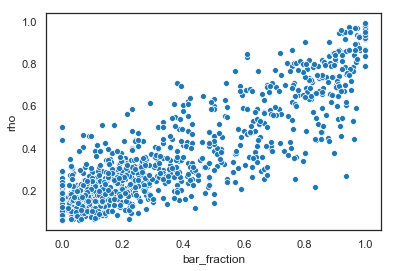

In [40]:
sns.scatterplot(data=gz2_dl_test_df, x='bar_fraction', y='rho')

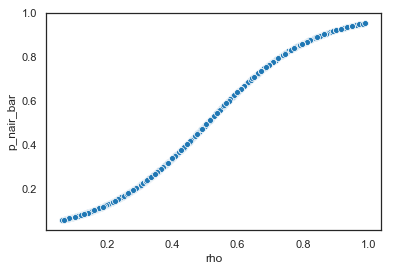

In [41]:
sns.scatterplot(data=gz2_dl_test_df, x='rho', y='p_nair_bar')

In [42]:
# # bootstrap sample for distribution of bar probabilities
# n_samples = 100
# votes = np.zeros((len(test_df), n_samples))
# for galaxy_n in range(len(test_df)):
#     for sample_n in range(n_samples):
#         votes[galaxy_n, sample_n] = np.random.choice(
#             list(range(n_votes)),
#             p=gz2_dl_probs[galaxy_n, :]
#         )

In [43]:
# votes

In [44]:
# votes_data = []
# for galaxy_n in range(len(votes)):
#     for sample_n in range(n_samples):
#         votes_data.append(
#             {'galaxy': galaxy_n, 'sample': sample_n, 'votes': votes[galaxy_n, sample_n]}
#         )
# votes_df = pd.DataFrame(data=votes_data)

In [45]:
# df = votes_df[votes_df['galaxy'] < 10]
# sns.barplot(data=df, x='galaxy', y='votes')

In [46]:
# vote_fractions = votes / n_votes

Text(0,0.5,'True Positive Rate')

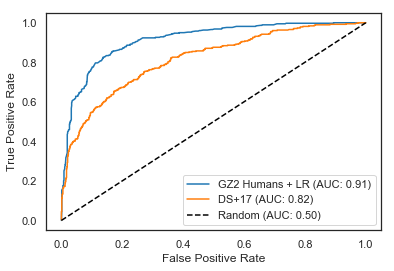

In [47]:
import sklearn

ds_n_predictions = test_df['P_bar_Nair10']  # model trained on Nair to predict Nair
ds_g_predictions = test_df['P_bar_GZ2'] # model trained on GZ2 to predict barredness

fpr_gz2, tpr_gz2, _ = sklearn.metrics.roc_curve(test_df['has_bar'], gz2_predictions)
auc_gz2 = sklearn.metrics.roc_auc_score(test_df['has_bar'], gz2_predictions)

fpr_ds_n, tpr_ds_n, _ = sklearn.metrics.roc_curve(test_df['has_bar'], ds_n_predictions)
auc_ds_n = sklearn.metrics.roc_auc_score(test_df['has_bar'], ds_n_predictions)

# dl_bar_predictions.sum()

fig, ax = plt.subplots()
ax.plot(fpr_gz2, tpr_gz2, label='GZ2 Humans + LR (AUC: {:.2f})'.format(auc_gz2))
ax.plot(fpr_ds_n, tpr_ds_n, label='DS+17 (AUC: {:.2f})'.format(auc_ds_n))
# ax.plot(fpr_ds_g, tpr_ds_g, label='DS18-G (AUC: {:.2f})'.format(auc_ds_g))
ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC: 0.50)')
ax.legend()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

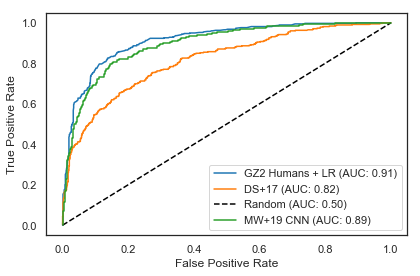

In [48]:

fpr_dl, tpr_dl, _ = sklearn.metrics.roc_curve(gz2_dl_test_df['has_bar'], gz2_dl_test_df['p_nair_bar'])
auc_dl = sklearn.metrics.roc_auc_score(gz2_dl_test_df['has_bar'], gz2_dl_test_df['p_nair_bar'])
ax.plot(fpr_dl, tpr_dl, label='MW+19 CNN (AUC: {:.2f})'.format(auc_dl))
ax.legend()
fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'nair_bar_roc.png'))
fig

correct: 90% of unbarred, 80% of strong barred?

In [49]:
from sklearn.metrics import confusion_matrix

In [50]:
confusion_matrix(test_df['has_bar'], ds_n_predictions > 0.5) / len(test_df)

array([[0.54665566, 0.14037985],
       [0.10156895, 0.21139554]])

In [51]:
confusion_matrix(gz2_dl_test_df['has_bar'], gz2_dl_test_df['p_nair_bar'] > 0.5) / len(gz2_dl_test_df)

array([[0.6409002 , 0.03913894],
       [0.13307241, 0.18688845]])

You can do a much better job predicting what Nair would have said (bar/no bar) using the GZ2 bar fraction + logistic regression than using the 'improved' DS catalog.

DS doesn't report the train/test split - we'll have to ignore that for now, and perhaps send an email.

- matched_train -> fit logistic regression WWND
- matched_test -> how well can we predict what Nair would have said, using gz2 votes?
- matched_test -> how well does ds predict what Nair would have said
- matched_test + dl -> how well can we predict what Nair would have said, using gz2 dl-inferred votes?

(matched = gz2 + nair intersection

In [52]:
# from zoobot.uncertainty import dropout_calibration

# dl_bar_predictions_all = np.stack([
#     p_bar_given_gz(pd.Series(vote_fractions[:, n])) for n in range(vote_fractions.shape[1])],
#     axis=1
# )



In [53]:
# dl_bar_predictions_all.shape

This is a good thing to do, but should be for value of posteriors not for DL comparison - DS didn't publish GZ estimates.
But maybe someone else did? Would make life much easier!

In [54]:
# test_df['log_m_'].sample(10)

In [55]:
# dl_bar_predictions_all[:, 0]

In [56]:
# ax = sns.jointplot(test_df['log_m_'], ds_g_predictions, xlim=[8, 12], kind='hex')

In [57]:
# df = test_df[(8 < test_df['log_m_']) &  (test_df['log_m_'] < 12)]

In [58]:
# galaxies, bins = np.histogram(df['log_m_'])
# bars, _ = np.histogram(df[df['has_bar']]['log_m_'], bins=bins)

In [59]:
# def get_bin_centers(bins):
#     return [np.mean(bin_pair) for bin_pair in zip(bins[:-1], bins[1:])]

In [60]:
# plt.errorbar(get_bin_centers(bins), values, yerr=np.sqrt(galaxies), fmt='o', markersize=4)

In [61]:
# fig, ax = plt.subplots()
# ax.scatter(test_df['log_m_'], dl_bar_predictions_all[:, 0])
# ax.set_xlim([8, 12])

In [62]:
# ax = sns.jointplot(test_df['log_m_'], dl_bar_predictions_all[:, 0], xlim=[8, 12], kind='hex')

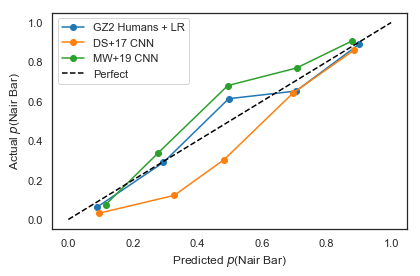

In [63]:
from sklearn.calibration import calibration_curve

fig, ax = plt.subplots()

n_bins = 5
marker = 'o'


prob_true, prob_pred = calibration_curve(test_df['has_bar'], gz2_predictions, n_bins=n_bins)
ax.plot(prob_pred, prob_true, label='GZ2 Humans + LR', marker=marker)

# prob_true, prob_pred = calibration_curve(test_df['has_bar'], ds_g_predictions, n_bins=n_bins)
# ax.plot(prob_pred, prob_true, label='g', marker=marker)

prob_true, prob_pred = calibration_curve(test_df['has_bar'], ds_n_predictions, n_bins=n_bins)
ax.plot(prob_pred, prob_true, label='DS+17 CNN', marker=marker)


prob_true, prob_pred = calibration_curve(gz2_dl_test_df['has_bar'], gz2_dl_test_df['p_nair_bar'], n_bins=n_bins)
ax.plot(prob_pred, prob_true, label='MW+19 CNN', marker=marker)


ax.plot([0, 1], [0, 1], 'k--', label='Perfect')
ax.set_xlabel('Predicted $p$(Nair Bar)')
ax.set_ylabel('Actual $p$(Nair Bar)')
plt.legend()
fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'ds_calibration_latest.png'))

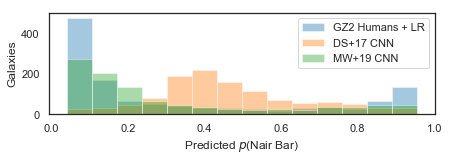

In [71]:
fig, ax = plt.subplots(figsize=(6.4, 2.4))
alpha = 0.4
n_bins = 14
_, bins, _ = ax.hist(gz2_predictions, alpha=alpha, bins=n_bins, density=False, label='GZ2 Humans + LR')
ax.hist(ds_n_predictions, bins=bins, alpha=alpha, density=False, label='DS+17 CNN')
ax.hist(gz2_dl_test_df['p_nair_bar'], alpha=alpha, bins=bins, density=False, label='MW+19 CNN')
ax.set_xlabel(r'Predicted $p$(Nair Bar)')
ax.set_ylabel('Galaxies')
ax.legend()
fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'prediction_histograms'))

In [66]:
len(test_df) / len(gz2_dl_test_df)

1.1849315068493151

In [67]:
len(gz2_dl_test_df)

1022

In [68]:
len(test_df)

1211

In [69]:
test_df['has_bar'].sum()

379

           catalog  predicted_bars
0  GZ2 Humans + LR      396.136167
1            DS+17      559.040709
2        MW+19 CNN      372.650309
actual bars 379


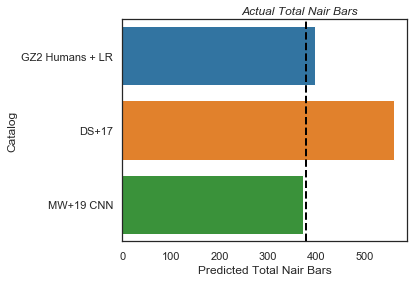

In [70]:
data = [
    {'catalog': 'GZ2 Humans + LR', 'predicted_bars': gz2_predictions.sum()},
    {'catalog': 'DS+17', 'predicted_bars': ds_n_predictions.sum()},
    {'catalog': 'MW+19 CNN', 'predicted_bars': gz2_dl_test_df['p_nair_bar'].sum() * (len(test_df) / len(gz2_dl_test_df))}
]
bar_totals_df = pd.DataFrame(data=data)
print(bar_totals_df)
fig, ax = plt.subplots()
sns.barplot(data=bar_totals_df, x='predicted_bars', y='catalog', ax=ax)
ax.set_ylabel('Catalog')
ax.set_xlabel('Predicted Total Nair Bars')
ax.axvline(test_df['has_bar'].sum(), linestyle='--', color='k', linewidth=2.)
print('actual bars', test_df['has_bar'].sum())
ax.text(.62, 1.02, 'Actual Total Nair Bars', transform=ax.transAxes, horizontalalignment='center', fontstyle='italic')
fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'ds_total_bars_latest.png'))